<a href="https://colab.research.google.com/github/nehdiii/Face_Landmarks_Detection_Useing_Mtcnn/blob/main/Building_Mtcnn_Model_And_Apply_It_In_Real_Time_Face_Landmark_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro


face detection and landmark detection is one of the important building blocks of modern application and technologies like snapchat filters and many devices use this tech 

in this note book i will walk through the implementation of Multi-task Cascaded Convolutional Networks [link of research paper](https://https://arxiv.org/abs/1604.02878) proposed by Kaipeng Zhang, Zhanpeng Zhang, Zhifeng Li, Yu Qiao
and apply it in real time face detection app useing opencv also i will implement the networks with tensorflow

#networks architecture and piplines

according to the paper the Mtcnn is composed with 3 separat convolutional neural networks 


*   P-Net
*   R-Net
*   O-Net 

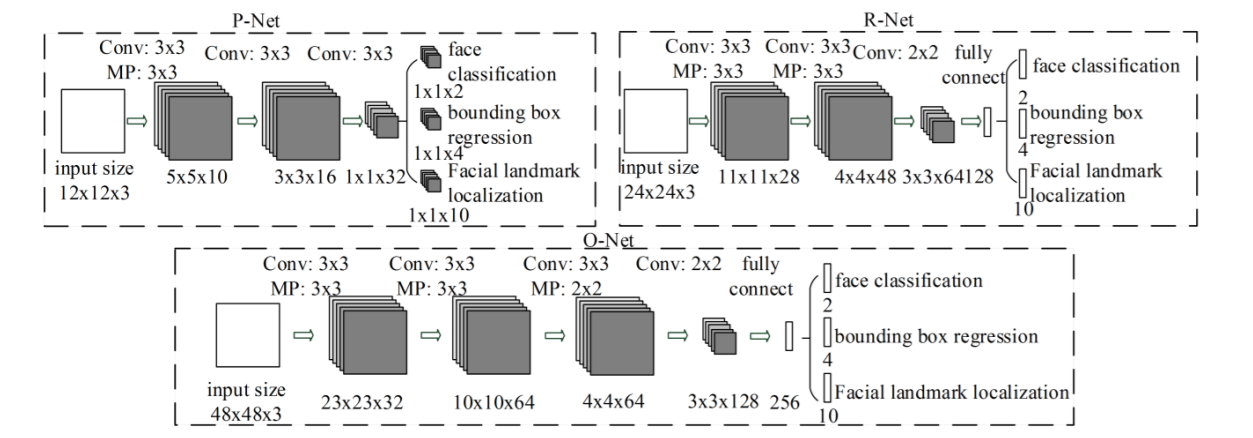



#The Proposal Network (P-Net)

is a fully convolutional network (FCN). The difference between a CNN and a FCN is that a fully convolutional network does not use a dense layer as part of the architechture. This Proposal Network is used to obtain candidate windows and their bounding box regression vectors.

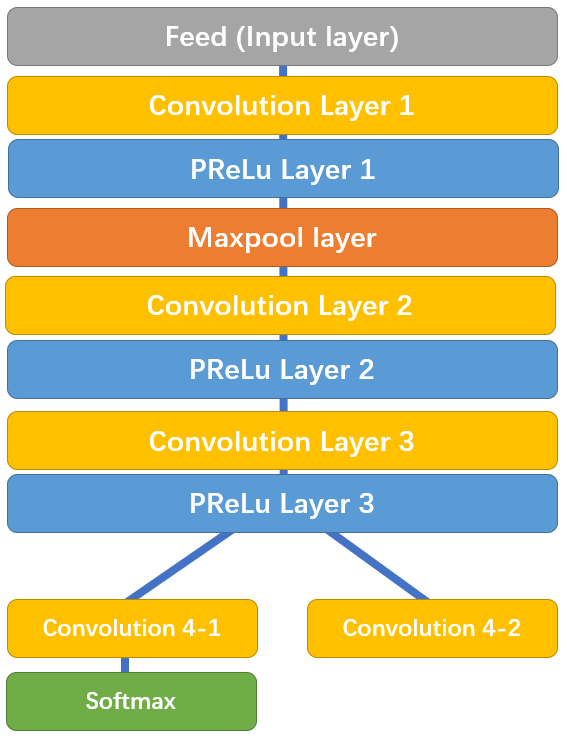

Convolution 4–1 outputs the probability of a face being in each bounding box, and convolution 4–2 outputs the coordinates of the bounding boxes.

#The Refine Network (R-Net)



 that this network is a CNN, not a FCN like the one before since there is a dense layer at the last stage of the network architecture.

 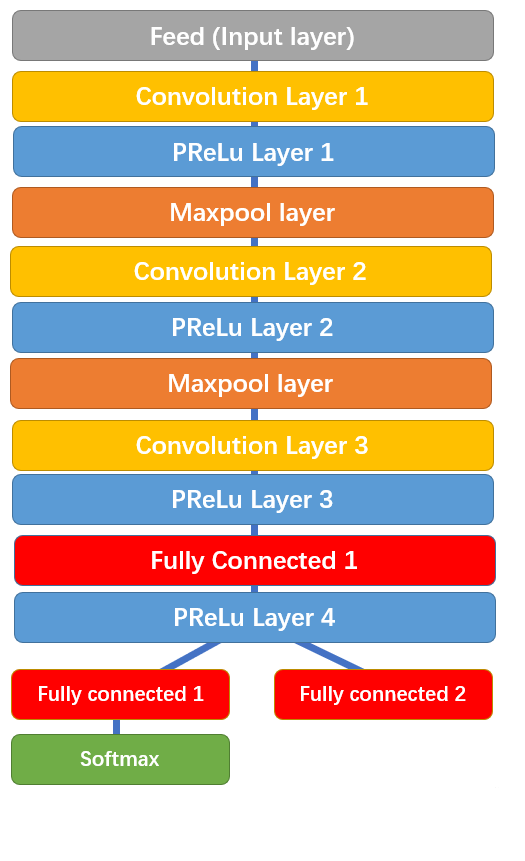

Similarly, R-Net splits into two layers in the end, giving out two outputs: the coordinates of the new bounding boxes and the machine’s confidence in each bounding box.

#The Output Network (O-Net)

This stage is similar to the R-Net, but this Output Network aims to describe the face in more detail and output the five facial landmarks’ positions for eyes, nose and mouth.

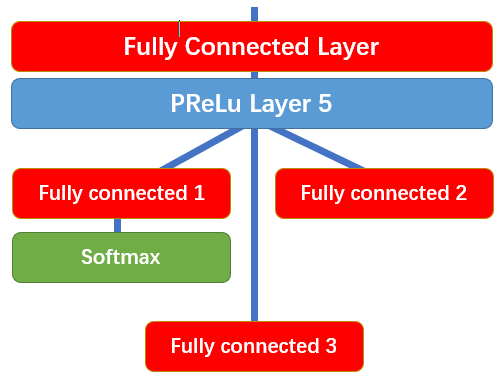

O-Net splits into 3 layers in the end, giving out 3 different outputs: the probability of a face being in the box, the coordinates of the bounding box, and the coordinates of the facial landmarks (locations of the eyes, nose, and mouth).

in the end we notice the mtcnn model perform 3 tasks is the output : 
face/non-face classification, bounding box regression, and facial landmark localization.

#MTCNN Architecture

in this section i will implement a class that carry out the architecture for each net of  the model 

In [1]:
# dependencies
import tensorflow as tf
from tensorflow.keras import Model, Input, layers
import math
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import HTML
from base64 import b64encode
from matplotlib.patches import Rectangle
import time

In [2]:
class MTCNN_Model_Archi(object):
  # constructeur 
  def __init__(self,Pnet_WeightsMat_Path,Rnet_WeightsMat_Path,Onet_WeightsMat_Path):
    """
      for this project we are useing the transfer learning approch so we need to use pretrained mtcnn weights so perfrom good perdiction 
      Pnet_WeightsMat_Path,Rnet_WeightsMat_Path,Onet_WeightsMat_Path : are paths to weights matrices to initiate our model 
    """
    self.PnetPath = Pnet_WeightsMat_Path
    self.RnetPath = Rnet_WeightsMat_Path
    self.OnetPath = Onet_WeightsMat_Path
  def PNet(self):
    """ Proposal Network, receives an image and outputs
    bounding box offset regressions and confidence scores for each sliding
    window of 12x12
    """
    img_in = Input(shape=(None, None, 3))

    # permute needed because of imported weights
    x = layers.Permute((2, 1, 3), name='permute')(img_in)
    x = layers.Conv2D(10, 3, 1, name='conv1')(x)
    x = layers.PReLU(shared_axes=[1, 2], name='prelu1')(x)
    x = layers.MaxPool2D(2, 2, padding='same', name='pool1')(x)

    x = layers.Conv2D(16, 3, 1, name='conv2')(x)
    x = layers.PReLU(shared_axes=[1, 2], name='prelu2')(x)

    x = layers.Conv2D(32, 3, 1, name='conv3')(x)
    x = layers.PReLU(shared_axes=[1, 2], name='prelu3')(x)

    # permute needed because of imported weights
    a = layers.Conv2D(2, 1, 1, name='conv4_1')(x)
    a = layers.Softmax()(a)
    a = tf.transpose(a, (0, 2, 1, 3))
    b = layers.Conv2D(4, 1, 1, name='conv4_2')(x)
    b = tf.transpose(b, (0, 2, 1, 3))

    model = Model(inputs=[img_in], outputs=[a, b])
    # this to load h5 files of pre-trained weghits 
    if self.PnetPath is not None:
        model.load_weights(self.PnetPath)
    return model
#-------------------------------------------------------------------------------
  def RNet(self):
    """ Refine Network, receives image crops from PNet and outputs
    further offset refinements and confidence scores to filter out
    the predictions
    """
    img_in = Input(shape=(24, 24, 3))
    # permute needed because of imported weights
    x = layers.Permute((2, 1, 3), name='permute')(img_in)
    x = layers.Conv2D(28, 3, 1, name='conv1')(x)
    x = layers.PReLU(shared_axes=[1, 2], name='prelu1')(x)
    x = layers.MaxPool2D(3, 2, padding='same', name='pool1')(x)

    x = layers.Conv2D(48, 3, 1, name='conv2')(x)
    x = layers.PReLU(shared_axes=[1, 2], name='prelu2')(x)
    x = layers.MaxPool2D(3, 2, name='pool2')(x)

    x = layers.Conv2D(64, 2, 1, name='conv3')(x)
    x = layers.PReLU(shared_axes=[1, 2], name='prelu3')(x)

    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(128, name='dense4')(x)
    x = layers.PReLU(name='prelu4')(x)

    a = layers.Dense(2, name='dense5_1')(x)
    a = layers.Softmax()(a)
    b = layers.Dense(4, name='dense5_2')(x)

    model = Model(inputs=[img_in], outputs=[a, b])
    if self.RnetPath is not None:
        model.load_weights(self.RnetPath)
    return model
#-------------------------------------------------------------------------------
  def ONet(self):
    """ Output Network, receives image crops from RNet and outputs
    final offset regressions, facial landmark positions and confidence scores
    """
    img_in = Input(shape=(48, 48, 3))
    # permute needed because of imported weights
    x = layers.Permute((2, 1, 3), name='permute')(img_in)
    x = layers.Conv2D(32, 3, 1, name='conv1')(x)
    x = layers.PReLU(shared_axes=[1, 2], name='prelu1')(x)
    x = layers.MaxPool2D(3, 2, padding='same', name='pool1')(x)

    x = layers.Conv2D(64, 3, 1, name='conv2')(x)
    x = layers.PReLU(shared_axes=[1, 2], name='prelu2')(x)
    x = layers.MaxPool2D(3, 2, name='pool2')(x)

    x = layers.Conv2D(64, 3, 1, name='conv3')(x)
    x = layers.PReLU(shared_axes=[1, 2], name='prelu3')(x)
    x = layers.MaxPool2D(2, 2, padding='same', name='pool3')(x)

    x = layers.Conv2D(128, 2, 1, name='conv4')(x)
    x = layers.PReLU(shared_axes=[1, 2], name='prelu4')(x)

    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(256, name='dense5')(x)
    x = layers.PReLU(name='prelu5')(x)

    a = layers.Dense(2, name='dense6_1')(x)
    a = layers.Softmax()(a)
    b = layers.Dense(4, name='dense6_2')(x)
    c = layers.Dense(10, name='dense6_3')(x)

    model = Model(inputs=[img_in], outputs=[a, b, c])
    if self.OnetPath is not None:
        model.load_weights(self.OnetPath)
    return model

In [3]:
test_mtcnn_archi = MTCNN_Model_Archi('/content/pnet.h5','/content/rnet.h5','/content/onet.h5')

In [4]:
print(test_mtcnn_archi.PNet())
print(test_mtcnn_archi.RNet())
print(test_mtcnn_archi.ONet())

this <keras.engine.functional.Functional object at 0x7f0c0fe5ca10> will be used later to predict in each stage 

# tools for MTCNN and explanation of each stage 

## Stage 1 and tools 

the first thing to do would be to pass in an image to the program
in this model we want to create an **image pyramid** in order to detect faces of all different sizes we want to create different copies of the same image in different sizes

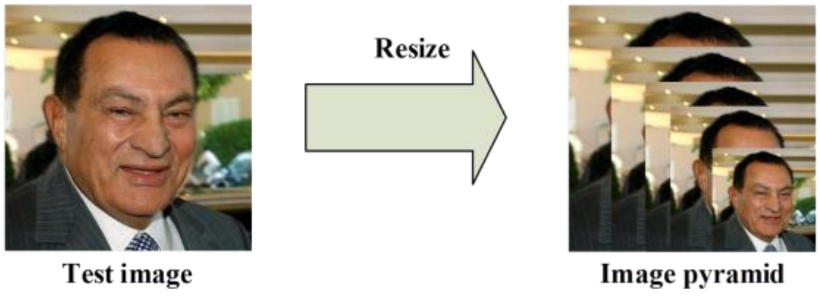 
later we will create methods calcualte sacles for pyramid resizeing 

For each scaled copy, we have a 12 x 12 stage 1 kernel(slideing window) that will go through every part of the image, scanning for faces. It starts in the top left corner, a section of the image from (0,0) to (12,12). This portion of the image is passed to P-Net, which returns the coordinates of a bounding box if it notices a face. and this movment of kernels is 
is defined with the pnet archi which means we dont need to pass many windows and run pnet many times this is the reason behined FC archi of 
pent 

Each kernel would be smaller relative to a large image, so it would be able to find smaller faces in the larger-scaled image. Similarly, the kernel would be bigger relative to a smaller sized image, so it would be able to find bigger faces in the smaller-scaled image.
the video explaine what im taling about 

In [5]:
mp4 = open('/content/y2meta.com - MTCNN Process Images(360p).mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

FileNotFoundError: ignored

we need to create multiple scaled copies of the image and pass it into the first neural net  PNet and gather its output.

we need to parse the PNet output to get a list of confidence levels for each bounding box, and delete the boxes with lower confidence (i.e. the boxes that the network isn’t quite sure contains a face)

After we’ve picked out the boxes with higher confidence
we will have to standardize the coordinate system

Since most kernels are in a scaled-down image, their coordinates will be based on the smaller image

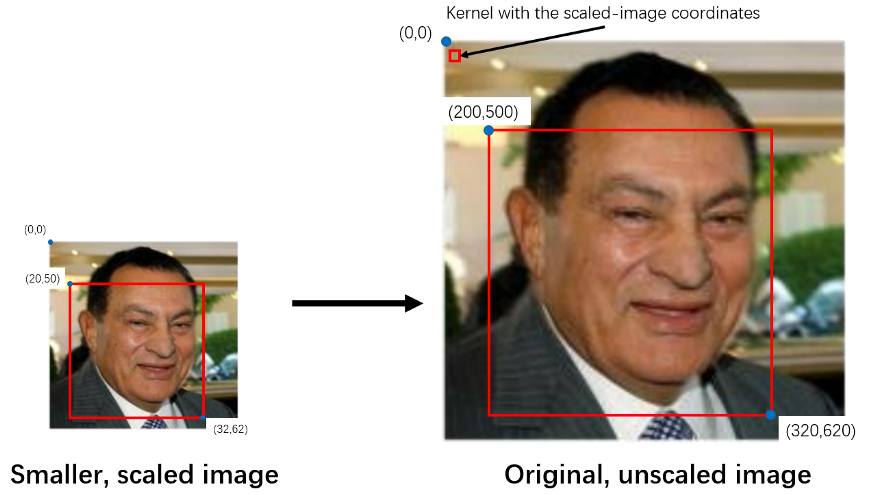




However, there are still a lot of bounding boxes left, and a lot of them overlap. Non-Maximum Suppression, or NMS, is a method that reduces the number of bounding boxes. if you want read more about 
Non-Maximum Suppression [link](https://https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c)
NMS returns a list of the “surviving” bounding boxes.

Why can’t we just choose the box with the highest confidence and delete everything else? There is only one face in the image above. However, there might be more than one face in other images. If so, we would end up deleting all the bounding boxes for the other faces.

  Now we convert the bounding box coordinates to coordinates of the actual image. Right now, the coordinates of each bounding box is a value between 0 and 1, with (0,0) as the top left corner of the 12 x 12 kernel and (1,1) as the bottom right corner (see table above). By multiplying the coordinates by the actual image width and height, we can convert the bounding box coordinates to the standard, real-sized image coordinates.

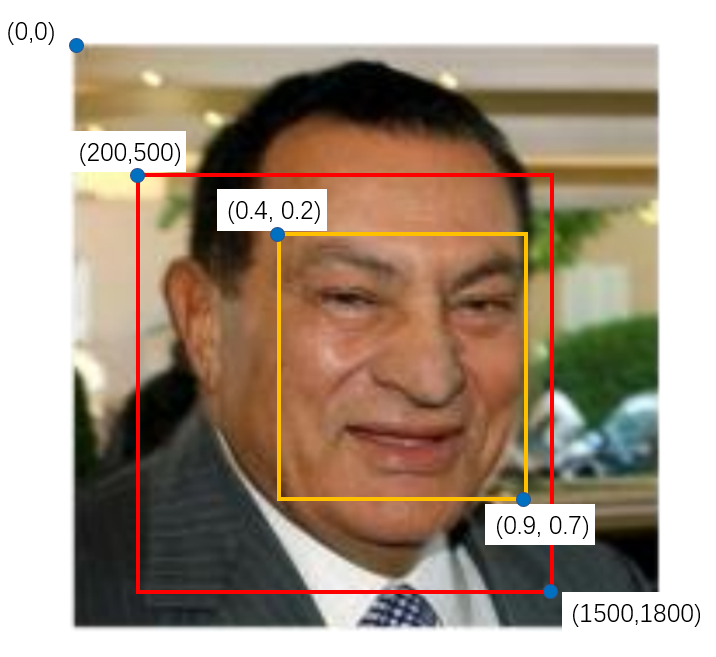

In this image, the red box represents the 24 x 24 kernel, resized back to the original image. We can calculate the width and height of the kernel: 1500–200 = 300, 1800–500 = 300 (Note how the width and height aren’t necessarily 12. That is because we’re using the coordinates of the kernel in the original image. The width and height we get here are the width and height of the kernel when scaled back to its original size.) Afterwards, we multiply the bounding box coordinates by 300: 0.4x300 = 120, 0.2x300 = 60, 0.9x300 = 270, 0.7x300 = 210. Finally, we add the top left coordinate of the kernel to get the coordinates of the bounding box: (200+120, 500+60) and (200+270, 500+210) or (320,560) and (470,710).

Since the bounding boxes may not be square, we then reshape the bounding boxes to a square by elongating the shorter sides (if the width is smaller than the height, we expand it sideways; if the height is smaller than the width, we expand it vertically).

## Stage 2 and tools 

Sometimes, an image may contain only a part of a face peeking in from the side of the frame. In that case, the network may return a bounding box that is partly out of the frame

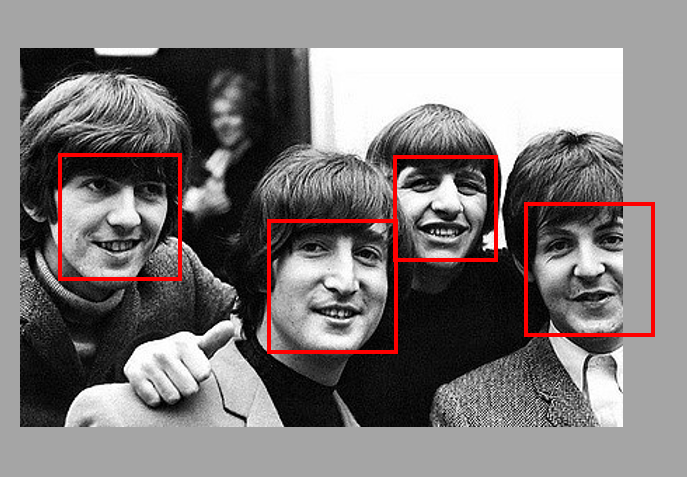

For every bounding box, we create an array of the same size, and copy the pixel values (the image in the bounding box) to the new array. If the bounding box is out of bounds, we only copy the portion of the image in the bounding box to the new array and fill in everything else with a 0.

After we pad the bounding box arrays, we resize them to 24 x 24 pixels, and normalize them to values between -1 and 1. Currently, the pixel values are between 0 to 255 (RGB values). By subtracting each pixel value by half of 255 (127.5) and dividing it by 127.5, we can keep their values between -1 and 1.

Now that we have numerous 24 x 24 image arrays(as many as the number of bounding boxes that survived Stage 1, since each of those bounding boxes has been resized and normalized into these kernels), we can feed them into R-Net and gather its output.

R-Net’s output is similar to that of P-Net: It includes the coordinates of the new, more accurate bounding boxes, as well as the confidence level of each of these bounding boxes.

Once again, we get rid of the boxes with lower confidence, and perform NMS on every box to further eliminate redundant boxes. Since the coordinates of these new bounding boxes are based on the P-Net bounding boxes, we need to convert them to the standard coordinates.



## Stage 3 and tools 

Before we can pass in the bounding boxes from R-Net, we have to first pad any boxes that are out-of-bounds. Then, after we resize the boxes to 48 x 48 pixels, we can pass in the bounding boxes into O-Net.

The outputs of O-Net are slightly different from that of P-Net and R-Net. O-Net provides 3 outputs: the coordinates of the bounding box , the coordinates of the 5 facial landmarks , and the confidence level of each box .

Once again, we get rid of the boxes with lower confidence levels, and standardize both the bounding box coordinates and the facial landmark coordinates. Finally, we run them through the last NMS. At this point, there should only be one bounding box for every face in the image.

# image normlization

In [111]:
# let's create a tools that perform image perprecessings
def Image_Normalization(image):
    """
    Preprocess image tensor before applying a network we make a normlization
    normalize values between -1 and 1
    input:
        img: image tensor
    output:
        float tensor with shape of image
    """
    image = (image - 127.5) * 0.0078125
    return image


original image


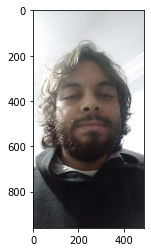

In [112]:
#test 
img = plt.imread("/content/271715354_1508899292829034_1378781638822795377_n.jpg")
print("original image")
plt.imshow(img)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normlized image


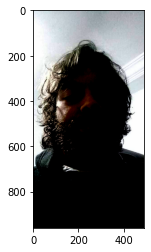

max pixel value 0.99609375
min pixel value -0.99609375


In [113]:
# let's normalize 
imgnorm = Image_Normalization(img)
print("normlized image")
plt.imshow(imgnorm)
plt.show()
print("max pixel value {}".format(imgnorm.max()))
print("min pixel value {}".format(imgnorm.min()))


#Generate bounding boxes from first net output 


i will test this function later when we get the outputs of Pnet 

In [114]:
def generate_bounding_boxs(probs,offsets,scale,threshold):
    """
    Convert output of PNet to bouding boxes tensor.
    input:
        probs: float tensor of shape [p, m, 2], output of PNet
        offsets: float tensor of shape [p, m, 4], output of PNet
        scale: float, scale of the input image
        threshold: float, confidence threshold
    output:
        float tensor of shape [n, 9]
    """
    #  print("offset shape before generating"+str(offsets.shape))
    #  print("proba shape before generating"+str(probs.shape))
    # applying P-Net is equivalent, in some sense, to
    # moving 12x12 window with stride 2
    stride = 2
    cell_size = 12
    probs = probs[:, :, 1]
    # indices of boxes where there is probably a face
    # inds: N x 2 we collect the probabilities index where we have goood proba indicating a face 
    inds = tf.where(probs > threshold)
    # inds [[120,2],[index line in image  of elemnet verifying cond,index column in image of elemnet verifying cond ],[200,5]............]
    # print("indicies of boxes detected" + str(inds.shape))
    if inds.shape[0] == 0: # we have no lines means no boxes means no proba biger than thresshold means no face detected retuns none 
        return tf.zeros((0, 9))
    # offsets: N x 4 is the top left and bottom right condination of box in image 
    offsets = tf.gather_nd(offsets, inds) # gather the offsets have good proba indiacteing the face 
    # print("offsets size after gathering"+str(offsets.shape)) 
    # tensor of size N x 4 conatine N offests of boxes with 4 index of top left and bottom right points  [[topleftx,toplefty,bottomrightx,bottomrighty],.............]
    # score: N x 1
    score = tf.expand_dims(tf.gather_nd(probs, inds), axis=1)
    # print("score shape"+str(score.shape))
    # tensor of shape N x 1 that conataine the proba of detecting a face [ porabOfbox1,................]
    # P-Net is applied to scaled images
    # so the coordinates we get is in the sacled images fig so we resacle the  bounging boxes to addapt with real image 
    inds = tf.cast(inds, tf.float32)
    # bounding_boxes: N x 9
    # in the end we resacle the bounding box indecies to adapt with real image then we add the proba and offsets in the the n x 9 vector 
    bounding_boxes = tf.concat([
        tf.expand_dims(tf.math.round((stride * inds[:, 1]) / scale), 1),
        tf.expand_dims(tf.math.round((stride * inds[:, 0]) / scale), 1),
        tf.expand_dims(tf.math.round((stride * inds[:, 1] + cell_size) / scale), 1),
        tf.expand_dims(tf.math.round((stride * inds[:, 0] + cell_size) / scale), 1),
        score, offsets
    ], 1)
    return bounding_boxes

#calibration 

In [115]:
def calibration(bounding_boxes,offsets):
    """
    Use offsets returned by a network to
    correct the bounding box coordinates.
    input:
        bounding_boxes: float tensor of shape [n, 4].
        offsets: float tensor of shape [n, 4].
    output:
        float tensor of shape [n, 4]
    """  
    x1, y1, x2, y2 = [bounding_boxes[:, i] for i in range(4)]
    w = x2 - x1
    h = y2 - y1
    translation = tf.stack([w, h, w, h], 1) * offsets
    return bounding_boxes + translation

#Bounding box correction to square

In [116]:
def Boundingbox_correction_to_square(bounding_boxes):
    """Convert bounding boxes to a square form.
    Parameters:
        bounding_boxes: float tensor of shape [n, 4]
    Returns:
        float tensor of shape [n, 4]
    """
    x1, y1, x2, y2 = [bounding_boxes[:, i] for i in range(4)]
    h = y2 - y1
    w = x2 - x1
    max_side = tf.maximum(h, w)
    dx1 = x1 + w * 0.5 - max_side * 0.5
    dy1 = y1 + h * 0.5 - max_side * 0.5
    dx2 = dx1 + max_side
    dy2 = dy1 + max_side
    return tf.stack([
        tf.math.round(dx1),
        tf.math.round(dy1),
        tf.math.round(dx2),
        tf.math.round(dy2),
    ], 1)

<tf.Variable 'Variable:0' shape=(1, 4) dtype=float32, numpy=array([[764., 570., 892., 599.]], dtype=float32)>
tf.Tensor([[764. 520. 892. 648.]], shape=(1, 4), dtype=float32)


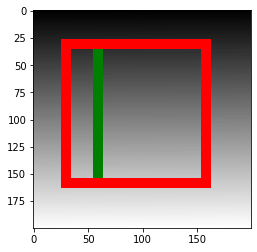

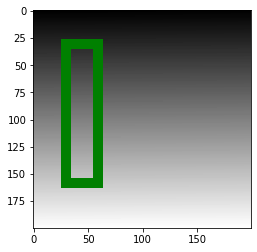

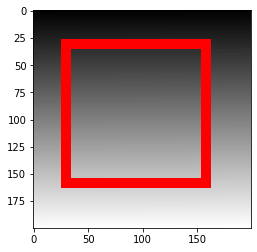

In [117]:
bbox_tensor = tf.Variable([[7.64000000e+02,  5.70000000e+02,  8.92000000e+02, 5.99000000e+02]])
print(bbox_tensor)  
non_corrected_h = bbox_tensor[:,2] - bbox_tensor[:,0]
non_corrected_w = bbox_tensor[:,3] - bbox_tensor[:,1]
corrected_bbox_tensor = Boundingbox_correction_to_square(bbox_tensor)
print(corrected_bbox_tensor)
corrected_h = corrected_bbox_tensor[:,2] - corrected_bbox_tensor[:,0]
corrected_w = corrected_bbox_tensor[:,3] - corrected_bbox_tensor[:,1]
# The image
X = np.arange(40000).reshape(200,200) 
# highlight some feature in the
# middle boxes.
fig = plt.figure()
  
ax = fig.add_subplot(111)
ax.imshow(X, cmap = plt.cm.gray,
          interpolation ='nearest')
ax.add_patch( Rectangle((30, 30),
                        non_corrected_w, non_corrected_h,
                        fc ='none', 
                        ec ='g',
                        lw = 10) )
ax.add_patch( Rectangle((30, 30),
                        corrected_w, corrected_h,
                        fc ='none', 
                        ec ='r',
                        lw = 10) )
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.imshow(X, cmap = plt.cm.gray,
          interpolation ='nearest')
ax1.add_patch( Rectangle((30, 30),
                        non_corrected_w, non_corrected_h,
                        fc ='none', 
                        ec ='g',
                        lw = 10) )
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.imshow(X, cmap = plt.cm.gray,
          interpolation ='nearest')
ax2.add_patch( Rectangle((30, 30),
                        corrected_w, corrected_h,
                        fc ='none', 
                        ec ='r',
                        lw = 10) )

plt.show()
# the green rectangle is resized to red 

#Croping images 

In [118]:
# this step used in stage 2 
def crope_image_boxes(bounding_boxes,image,height,width,num_boxes,size=24):
    """
    Cut out boxes from the image.
    input:
        bounding_boxes: float tensor of shape [n, 4]
        image: image tensor
        height: float, image height
        width: float, image width
        num_boxes: int, number of rows in bboxes
        size: int, size of cutouts
    output:
        float tensor of shape [n, size, size, 3]
    """
    # Note Sometimes, an image may contain only a part of a face peeking in from 
    #the side of the frame. In that case, the network may return a bounding box that is partly out of the frame
    # so when picking the cordinates of image we take max between x1 , y1 and 0 and for x2,y2 and height and width to stay in the frame 
    x1 = tf.math.maximum(bounding_boxes[:,0], 0.0) / width
    y1 = tf.math.maximum(bounding_boxes[:,1], 0.0) / height
    x2 = tf.math.minimum(bounding_boxes[:,2], width) / width
    y2 = tf.math.minimum(bounding_boxes[:,3], height) / height
    boxes = tf.stack([y1,x1,y2,x2],1)
    image_boxes = tf.image.crop_and_resize(tf.expand_dims(image,0),boxes,
                                           tf.zeros(num_boxes, dtype=tf.int32),
                                           (size,size))
    image_boxes = Image_Normalization(image_boxes)
    return image_boxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original image
(960, 490, 3)


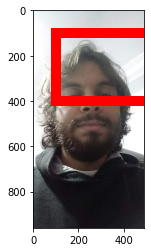

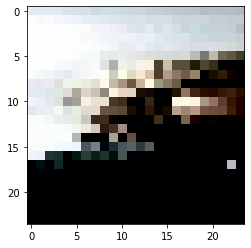

In [119]:
print("original image")
shape_ = img.shape
print(shape_)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(img)
# let's create some bounding boxes 
bbox_tensor = tf.Variable([[1.5,1.2,300.6,500.7]])
h = bbox_tensor[:,2] - bbox_tensor[:,0]
w = bbox_tensor[:,3] - bbox_tensor[:,1]
ax.add_patch( Rectangle((100, 100),
                        w, h,
                        fc ='none', 
                        ec ='r',
                        lw = 10) )
#now lets crop the image in the bounding box
img_croped = crope_image_boxes(bbox_tensor,img,490,960,1)
fig1 = plt.figure()
ax1 = fig1.add_subplot()
ax1.imshow(img_croped[0])
plt.show()

# feltring thresholds

In [120]:
DEF_THRESHOLDS = [0.7, 0.8, 0.9]
DEF_NMS_THRESHOLDS = [0.6, 0.6, 0.6]

#let's build up the MTCNN Class

## steps to follow 


Stage 1:


1. Pass in image
2. Create multiple scaled copies of the image
3. Feed scaled images into P-Net
4. Gather P-Net output
5. Delete bounding boxes with low confidence
6. Convert 12 x 12 kernel coordinates to “un-scaled image” coordinates
7. Non-Maximum Suppression for kernels in each scaled image
8. Non-Maximum Suppression for all kernels
9. Convert bounding box coordinates to “un-scaled image” coordinates
10. Reshape bounding boxes to square





Stage 2:

1. Pad out-of-bound boxes
2. Feed scaled images into R-Net
3. Gather R-Net output
4. Delete bounding boxes with low confidence
5. Non-Maximum Suppression for all boxes
6. Convert bounding box coordinates to “un-scaled image” coordinates
7. Reshape bounding boxes to square

Stage 3:


1. Pad out-of-bound boxes
2. Feed scaled images into O-Net
3. Gather O-Net output
4. Delete bounding boxes with low confidence
5. Convert bounding box and facial landmark coordinates to “un-scaled image” coordinates
6. Non-Maximum Suppression for all boxes

In [121]:
class MyMTCNN(object):
    """ class for mtcnn detection 
        step 1 lets define our class constructor
    """
  #--------------------------------------- constructor ----------------------------------------------------------------------------------------------------------
    def __init__(self,Pnet_WeightsMat_Path,Rnet_WeightsMat_Path,Onet_WeightsMat_Path,
                                                        Min_Face_Size = 20.0,
                                                        bounding_box_regression_Thresholds = None,
                                                        Non_Maximum_Suppression_Thresholds= None,
                                                        Max_output_size = 300 
                                                                        ):
      """
        Pnet_WeightsMat_Path,Rnet_WeightsMat_Path,Onet_WeightsMat_Path : are paths to weights matrices to initiate our model 
        Min_Face_Size : is the minimum image size we can feet to our model 
        bounding_box_regression_Thresholds : to calibrate the candidates windows
        Non_Maximum_Suppression_Thresholds : is  Non-Maximum Suppression Thresholds used  to merge highly overlapped candidates windows.
        Max_output_size : is the max output we need 
      """
      Mtcnn_archi = MTCNN_Model_Archi(Pnet_WeightsMat_Path,Rnet_WeightsMat_Path,Onet_WeightsMat_Path)
      self.Pnet =  Mtcnn_archi.PNet()
      self.Rnet =  Mtcnn_archi.RNet()
      self.Onet =  Mtcnn_archi.ONet()
      """
      Pnet / Rnet / Onet all contains the initiation of our model per networks a keras object <keras.engine.functional.Functional object at 0x7ff6f321bcd0> 
      u can check out the  the result of print last cell 

      """
      self.Min_Face_Size = Min_Face_Size
      self.bounding_box_regression_Thresholds = bounding_box_regression_Thresholds or DEF_THRESHOLDS
      self.Non_Maximum_Suppression_Thresholds = Non_Maximum_Suppression_Thresholds or DEF_NMS_THRESHOLDS
      self.Max_output_size = Max_output_size
      self.pyramid_scale_cache = {} 
  #---------------------------------------------------------------------------------------------------------------------------------------------------------------
      """ 
        now we need to care about the image preprocessing step
        first step let's builed a method can compute diffrent scales for us 
    """
    def get_pyramid_scales(self,image_height,image_width):
      """
        Compute scaling factors for given image dimensions

        input : 
            image_height : original image height 
            image_width : original image width 

        output : 
              list of floats , scaling factors 
      """
      Minimum_length = min(image_height,image_width)
      # note that when we do video streaming the height and width of the video feed will not change i will do this step 
      # later with opencv so lets do this step 
      if Minimum_length in self.pyramid_scale_cache:
        return self.pyramid_scale_cache[Minimum_length] # so if the minium length exist means video straming means applying algo many times while straming we dont need to calculate scales again
      # just return it 
      Minimum_detection_size = 12 # we can't go under 12 in scaleing bcz the Minimum size of the input in Pnet is 12*12*3 !!! 
      scale_factor = 0.707
      scale_list = [] # scales for image scaeling 
      # we need to sacle the image so that the min size we we can detect equal to min face size that we want to detect 
      m = Minimum_detection_size / self.Min_Face_Size
      Minimum_length *= m 
      factor_count = 0
      while Minimum_length > Minimum_detection_size:
        # while we still grater than mini size of image we can feed to net lets calculate the scale
        scale_list.append(m*scale_factor**factor_count)
        Minimum_length *= scale_factor
        factor_count += 1
      # after calculating scales for min length we store it in the cach for later usage 
      self.pyramid_scale_cache[Minimum_length] = scale_list
      return scale_list 
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    def Apply_PNet_On_Scaled_Image(self,image,image_height,image_width,scale):
          """
          Perform stage one part with a given scaling factor
          input:
              image: rgb image, float tensor of shape [h, w, 3]
              imgae_height: image height, float
              image_width: image width, float
              scale: scaling factor, float
          output
              float tensor of shape [n, 9]
          """
          # print("input image shape :"+str(image.shape))
          # preprocessing the image and make it ready to enter the PNet 
          height_scale = tf.math.ceil(image_height*scale) # get new scaled height  
          width_scale = tf.math.ceil(image_width*scale) # get new scaled width 
          # print(height_scale,width_scale)
          image_input = tf.image.resize(image,(height_scale,width_scale)) # resize the image useing new height and width
          # print("image size after resize :"+str(image_input.shape))
          image_input = Image_Normalization(image_input) # this step just to acclelrate training 
          image_input = tf.expand_dims(image_input,0)
          # print("image size after expand dims"+str(image_input.shape))
          # now let's tarine and the output from PNet will be the probabliltes of being face or non face and the offsets (the cordinate of top right corner in the 12*12 window in the image and 
          # the cordinates of bottom right corner of 12*12 window )

          probs,offsets = self.Pnet(image_input)
          #print("probabilities of boxes detected "+str(probs.shape))
          #print("boxes detected" + str(offsets.shape))
          
          # good now after geting the outputs from the first network let's generate the bounding boxs

          boxes =  generate_bounding_boxs(probs[0],offsets[0],scale,self.bounding_box_regression_Thresholds[0]) # probs[0] is m*p*2 tensor and offests[0] is m*p*4 tensor 
          # the output of pnet 
          if len(boxes) == 0: #if we dont have any box just return 
              return boxes 
          # else we apply non max suppression 
          keep = tf.image.non_max_suppression(boxes[:, 0:4], boxes[:, 4], self.Max_output_size,
                                              iou_threshold=0.5)
          boxes = tf.gather(boxes, keep)
          return boxes    

  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    def Pnet_filter(self,boxes):
            """
            Filter out boxes in stage one
            input :
                boxes: collected boxes with different scales, float tensor of shape [n, 9]
                boxes is a list of  tensors with shape [n,9]
            output:
                float tensor of shape [n, 4]
            """
            bounding_boxes, scores , offsets = boxes[:, :4], boxes[:, 4], boxes[:, 5:]
          
            # use offsets predicted by pnet to transform bounding boxes
            bounding_boxes = calibration(bounding_boxes, offsets)
            """
                Since the bounding boxes may not be square, we then reshape the bounding boxes 
                to a square by elongating the shorter sides (if the width is smaller than the height, 
                we expand it sideways; if the height is smaller than the width, we expand it vertically).
            """
            bounding_boxes = Boundingbox_correction_to_square(bounding_boxes)

            keep = tf.image.non_max_suppression(bounding_boxes, scores, self. Max_output_size ,
                                                iou_threshold=self.Non_Maximum_Suppression_Thresholds[0])
            bounding_boxes = tf.gather(bounding_boxes, keep)
            return bounding_boxes
  
  #---------------------------------------------------------------------------------------------------
    def stage_one_of_Mtcnn(self,image,scales):
          """
        Run stage one on the input image
          input:
              image: rgb image, float tensor of shape [h, w, 3]
              scales: scaling factors, list of floats
          output:
              float tensor of shape [n, 4], predicted bounding boxes for each scale 
          """    
          height, width, _ = image.shape
          boxes = []
          # lets run pnet on diffrent scales 
          for scale in scales:
            boxes.append(self.Apply_PNet_On_Scaled_Image(image,height,width,scale))
          # collect boxes (and offsets, and scores) from different scales
          boxes = tf.concat(boxes, 0) # transfrom list of (nbscales,N,4) to tensor cc
          # if we we  have no boxes detected returne none 
          if boxes.shape[0] == 0:
              return []
          return self.Pnet_filter(boxes)

    def stage_two_of_Mtcnn(self,image,bounding_boxes,height,width,num_boxes):
          """Run stage two on the input image
          input:
              image: rgb image, float tensor of shape [h, w, 3]
              bounding_boxes: bounding boxes from stage one, float tensor of shape [n, 4]
              height: image height, float
              width: image width, float
              num_boxes: number of rows in bounding_boxes, int
          outputs:
              float tensor of shape [n, 4], predicted bounding boxes
          """
          # now we need to get the boxes from the image like cropping a part of image in the bounding box
          image_boxes = crope_image_boxes(bounding_boxes,image,height,width,num_boxes,size=24)
          # apply rnet to refine boxes
          probs,offsets = self.Rnet(image_boxes)
          # get new bounding boxes based on bbox reg thresholds
          keep = tf.where(probs[:,1] > self.bounding_box_regression_Thresholds[1])[:,0]
          bounding_boxes = tf.gather(bounding_boxes,keep)
          offsets = tf.gather(offsets,keep)
          scores = tf.gather(probs[:,1],keep)
          # calibrate and resquare  boxes 
          bounding_boxes = calibration(bounding_boxes,offsets)
          bounding_boxes = Boundingbox_correction_to_square(bounding_boxes)
          # apply non max supp 
          keep = tf.image.non_max_suppression(bounding_boxes, scores,
                                              self.Max_output_size, self.Non_Maximum_Suppression_Thresholds[1])
          bounding_boxes = tf.gather(bounding_boxes,keep)
          return bounding_boxes
    def stage_three_of_Mtcnn(self,image,bounding_boxes,height,width,num_boxes):
        """Run stage three on the input image
          input:
            image: rgb image, float tensor of shape [h, w, 3]
            bounding_boxes: bounding boxes from stage two, float tensor of shape [n, 4]
            height: image height, float
            width: image width, float
            num_boxes: number of rows in bboxes, int
          Returns:
            bounding_boxes: float tensor of shape [n, 4], face bounding boxes
            landmarks: float tensor of shape [n, 10], 5 facial landmarks,
                        first 5 numbers of array are x coords, last are y coords
            scores: float tensor of shape [n], confidence scores
        """
        image_boxes = crope_image_boxes(bounding_boxes,image,height,width,num_boxes,size=48)
        probs,offsets,landmarks = self.Onet(image_boxes)
        keep = tf.where(probs[:,1] > self.bounding_box_regression_Thresholds[2])[:,0]
        bounding_boxes = tf.gather(bounding_boxes,keep)
        offsets = tf.gather(offsets,keep)
        scores = tf.gather(probs[:,1],keep)
        landmarks = tf.gather(landmarks, keep)

        # compute landmark points
        width = tf.expand_dims(bounding_boxes[:, 2] - bounding_boxes[:, 0] + 1.0, 1)
        height = tf.expand_dims(bounding_boxes[:, 3] - bounding_boxes[:, 1] + 1.0, 1)
        xmin = tf.expand_dims(bounding_boxes[:, 0], 1)
        ymin = tf.expand_dims(bounding_boxes[:, 1], 1)
        landmarks = tf.concat([xmin + width * landmarks[:, 0:5],
                               ymin + height * landmarks[:, 5:10]], 1)
        bounding_boxes = calibration(bounding_boxes,offsets)
        keep = tf.image.non_max_suppression(bounding_boxes, scores,
                                            self.Max_output_size, self.Non_Maximum_Suppression_Thresholds[2])
        bounding_boxes = tf.gather(bounding_boxes, keep)
        landmarks = tf.gather(landmarks, keep)
        scores = tf.gather(scores, keep)
        return bounding_boxes, landmarks, scores
    def detect(self, image):
        """Detect faces and facial landmarks on an image
        input:
            img: rgb image, numpy array of shape [h, w, 3]
        output:
            bounding_boxes: float tensor of shape [n, 4], face bounding boxes
            landmarks: float tensor of shape [n, 10], 5 facial landmarks,
                        first 5 numbers of array are x coords, last are y coords
            scores: float tensor of shape [n], confidence scores
        """
        test_cach = []
        height, width, _ = image.shape
        image = tf.convert_to_tensor(image, tf.float32)
        scales = self.get_pyramid_scales(height, width)
        bounding_boxes = self.stage_one_of_Mtcnn(image, scales)
        test_cach.append(bounding_boxes)
        if len(bounding_boxes) == 0:
            return [], [], []
        bounding_boxes = self.stage_two_of_Mtcnn(image, bounding_boxes, height, width, bounding_boxes.shape[0])
        test_cach.append(bounding_boxes)
        if len(bounding_boxes) == 0:
            return [], [], []
        bounding_boxes, landmarks, scores = self.stage_three_of_Mtcnn(image, bounding_boxes,
                                                     height, width, bounding_boxes.shape[0])
        test_cach.append(bounding_boxes)
        return bounding_boxes, landmarks, scores,test_cach

In [122]:
# let's test 
MT =  MyMTCNN('/content/pnet.h5','/content/rnet.h5','/content/onet.h5')
bboxes_tf, landmarks_tf, score_tf,test_cach_tf = MT.detect(img)

In [123]:
landmarks = ((landmarks_tf.numpy()).tolist())[0]

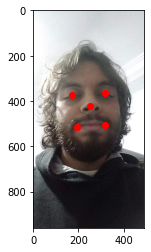

In [124]:
plt.imshow(img)
plt.scatter(landmarks[0:5],landmarks[5:],c='red')
plt.show()

#testing the stages

In [107]:
pnet_bbox = test_cach_tf[0]
rnet_bbox = test_cach_tf[1]
onet_bbox = test_cach_tf[2]

In [128]:
def draw_bbox(img, bboxes):
    """ draw bounding boxes """
    for box in bboxes:
        img = cv2.rectangle(img, (int(box[0]), int(box[1])),
                            (int(box[2]), int(box[3])), (255, 0, 0), 2)
    return img
# this function take list of bounding boxes and draw them in the image 

#progress of training 

Text(0.5, 1.0, 'Onet output')

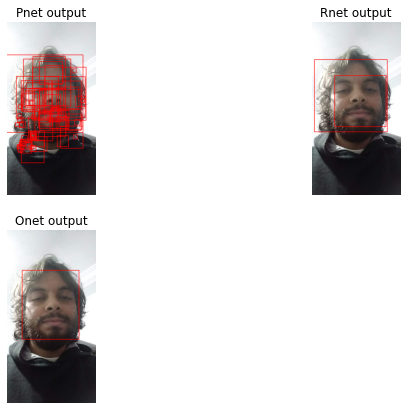

In [129]:
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2
names  = ['Pnet output','Rnet output','Onet output']


image1 = img.copy()
image2 = img.copy()
image3 = img.copy()
fig.add_subplot(rows, columns,1)
image1 = draw_bbox(image1,pnet_bbox)
plt.imshow(image1)
plt.axis('off')
plt.title(names[0])
fig.add_subplot(rows, columns,2)
image2 = draw_bbox(image2,rnet_bbox)
plt.imshow(image2)
plt.axis('off')
plt.title(names[1])
fig.add_subplot(rows, columns,3)
image3 = draw_bbox(image3,onet_bbox)
plt.imshow(image3)
plt.axis('off')
plt.title(names[2])